## 사전 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U sentencepiece datasets transformers pyarrow polyleven pytorch-lightning -q

In [ ]:
import os
import re
import json
import glob, shutil
import xml.etree.ElementTree as elemTree
from collections import Counter
from itertools import chain
from pathlib import Path
from typing import List, Dict, Union, Tuple, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from transformers import (
    DonutProcessor,
    VisionEncoderDecoderConfig,
    VisionEncoderDecoderModel,
    get_scheduler
)
from datasets import Dataset
from datasets import Image as ds_img
from polyleven import levenshtein

In [ ]:
!git clone https://github.com/KDTAI-A3/kr-img2latex.git
%cd kr-img2latex

fatal: destination path 'kr-img2latex' already exists and is not an empty directory.
/content/kr-img2latex


## 데이터 압축 해제 및 정리

### Download Data

In [ ]:
%cd data
!chmod u+x ./download.sh
!./download.sh

[Errno 2] No such file or directory: 'data'
/content
chmod: cannot access './download.sh': No such file or directory
/bin/bash: ./download.sh: No such file or directory


In [ ]:
!python ./unzip.py

python3: can't open file '/content/./unzip.py': [Errno 2] No such file or directory


In [ ]:
images_path = glob.glob('/content/kr-img2latex/data/train/images/*')
train_json_files = glob.glob('/content/kr-img2latex/data/train/annotations/*')

### For Temporary Drive

In [ ]:
train_annotation_paths = glob.glob('/content/drive/MyDrive/programmers/Team_caffeine_holic/01.데이터/1.Training/라벨링데이터/*.zip')
train_image_paths = glob.glob('/content/drive/MyDrive/programmers/Team_caffeine_holic/01.데이터/1.Training/원천데이터/*.zip')

In [ ]:
# 임시적으로 생성

def organize_train_dataset(value: str) -> list:
  """
    Unzip all train data files and organize train dataset.
    It will be created on the directory '/content/train'.

    Args:
        value (str): The value must be either 'images' or 'annotations'.

    Returns:
        list: File path list of the dataset.
  """
  extract_dir = f'./train/{value}'
  archive_format = 'zip'

  if value == 'annotations':
    file_paths = train_annotation_paths
  else:
    file_paths = train_image_paths

  for filename in file_paths:
    shutil.unpack_archive(filename, extract_dir, archive_format)

  for folder_name, _, file_names in os.walk(extract_dir):
    if len(file_names) > 0:
      for f in file_names:
        current_file = os.path.join(folder_name, f)
        shutil.move(current_file, extract_dir)

  folder_name, sub_folders, _ = next(iter(os.walk(extract_dir)))
  for sf in sub_folders:
    shutil.rmtree(os.path.join(folder_name, sf))

  return glob.glob(os.path.join(extract_dir,'*'))

In [ ]:
images_path = organize_train_dataset('images')
train_json_files = organize_train_dataset('annotations')

StopIteration: ignored

In [ ]:
images_path

[]

In [ ]:
assert len(images_path) == len(train_json_files)

## Check Samples

In [ ]:
sample_img = np.random.choice(images_path)
sample_json = sample_img.replace('images','annotations').replace('.png','.json')

In [ ]:
Image.open(sample_img)

In [ ]:
with open(Path(sample_json)) as jf:
  temp_json = json.load(jf)

In [ ]:
temp_json

{'id': 'b1cb1dc5-92cf-47b7-83b3-c158bc781b45',
 'chapter_id': '813',
 'material_type': '손글씨',
 'segments': [{'box': [[0, 0], [88, 0], [88, 26], [0, 26]],
   'type': '수식/텍스트',
   'type_detail': '수식',
   'equation': '$b=0$'}]}

In [ ]:
temp_json['segments']

[{'box': [[0, 0], [88, 0], [88, 26], [0, 26]],
  'type': '수식/텍스트',
  'type_detail': '수식',
  'equation': '$b=0$'}]

$\int_{-1}^{1}\left|x^{3}-x\right| d x=\int_{-1}^{0}\left(x^{3}-x\right) d x+\int_{0}^{1}\left(-x^{3}+x\right) d x$

$\displaystyle {a_{n+1}}^{2} = a_{n+2} \times a_{n} \to $ 등비수열

$\displaystyle d$ 면

## Config

In [ ]:
class CFG:

    # General
    debug = False
    num_proc = 4
    num_workers = 4
    gpus = 1

    # Data
    max_length = 480 # 256
    image_height = 480
    image_width = 480

    # Training
    epochs = 1 # 빠른 확인을 위해 1로 설정, 2로 설정하는 것을 추천
    val_check_interval = 1.0  # how many times we want to validate during an epoch
    check_val_every_n_epoch = 1
    gradient_clip_val = 1.0
    lr = 3e-5
    lr_scheduler_type = "cosine"
    num_warmup_steps = 100
    seed = 42
    warmup_steps = 300
    output_path = "output"
    log_steps = 200
    batch_size = 8
    use_wandb = False

## Add Special Tokens

In [ ]:
PROMPT_TOKEN = "<TPT>"
LINE_START = "<line>"
LINE_END = "</line>"
LATEX_START = "<latex>" # $ 가 라텍스 문법을 구분하는 토큰
LATEX_END = "</latex>"
HAND_TOKEN = "<hand>"
PRINT_TOKEN = "<print>"


SEPARATOR_TOKENS = [
    PROMPT_TOKEN,
    LINE_START,
    LINE_END,
    LATEX_START,
    LATEX_END,
    HAND_TOKEN,
    PRINT_TOKEN,
]

new_tokens = SEPARATOR_TOKENS

In [ ]:
def get_gt_string(filepath: Union[str, os.PathLike]) -> Dict[str, str]:
    """
    Get the ground truth string and x-y data from the given JSON file.

    Args:
        filepath (str): The path to the JSON file

    Returns:
        dict: A dictionary containing the ground truth string, material type, and id
    """
    filepath = Path(filepath)

    with open(filepath, encoding='utf-8') as fp:
        data = json.load(fp)

    data_series = data["segments"]

    all_lines = []

    NON_OBJECT = False

    for d_line in data_series:
      if 'equation' not in d_line: # 도형, 그래프 제외
        NON_OBJECT = True
        break

      if '$' not in d_line['equation']:
        new_line = LINE_START + d_line['equation'] + LINE_END
      else:
        equation = d_line['equation'].split('$')
        latex_line = equation[0]
        for i, e in enumerate(equation[1:]):
          if i%2 == 0:
            latex_line += LATEX_START + e
          else:
            latex_line += LATEX_END + e

        new_line = LINE_START + latex_line + LINE_END

      all_lines.append(new_line)

    if not NON_OBJECT:
      if data['material_type'] == '손글씨':
        material_type = HAND_TOKEN
      else:
        material_type = PRINT_TOKEN

      string_lines = "".join(all_lines)

      gt_string = PROMPT_TOKEN + material_type + string_lines

      return {
          "ground_truth": gt_string,
          "material_type": data["material_type"],
          "id": data['id']
      }

    else:
      return False

In [ ]:
get_gt_string(sample_json)

{'ground_truth': '<TPT><hand><line><latex>b=0</latex></line>',
 'material_type': '손글씨',
 'id': 'b1cb1dc5-92cf-47b7-83b3-c158bc781b45'}

## 데이터셋 구축

In [ ]:
def gen_data(files: List[Union[str, os.PathLike]]) -> Dict[str, str]:
    """
    This function takes a list of json files and returns a generator that yields a
    dictionary with the ground truth string and the path to the image.

    Args:
        files (list): A list of json files

    Returns:
        generator: A generator that yields a dictionary with the ground truth string and
            the path to the corresponding image.
    """

    for f in files:

        result = get_gt_string(f)
        if result:
          yield {
              **result,
              "image_path": f.replace('annotations','images').replace('.json','.png')
          }


ds = Dataset.from_generator(
    gen_data, gen_kwargs={"files": train_json_files}, num_proc=CFG.num_proc
)

## 이미지 사이즈 확인

In [ ]:
def add_image_sizes(examples: Dict[str, Union[str, os.PathLike]]) -> Dict[str, List[int]]:
    """
    This function takes a dictionary of examples and adds the width and height of the
    image to the dictionary. This is to be used with the `Dataset.map` function.

    Args:
        examples (dict): A dictionary of examples (from `map` function)

    Returns:
        dict: The dictionary with the width and height of the image added
    """

    sizes = [Image.open(x).size for x in examples["image_path"]]

    width, height = list(zip(*sizes))

    return {
        "width": list(width),
        "height": list(height),
    }


ds = ds.map(add_image_sizes, batched=True, num_proc=CFG.num_proc)

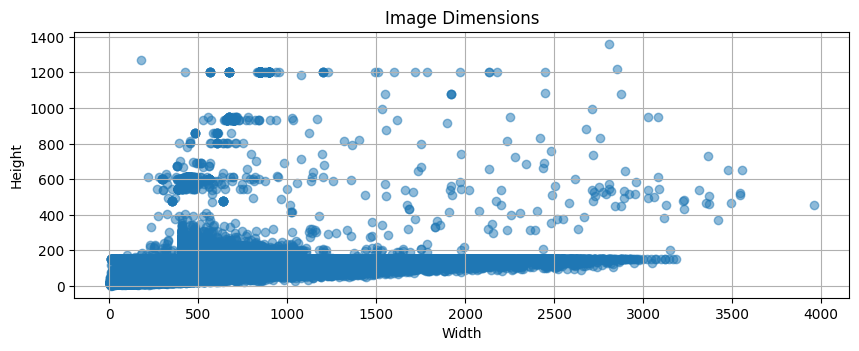

In [ ]:
plt.figure(figsize=(10, 10))

plt.scatter(x=ds["width"], y=ds["height"], marker="o", alpha=0.5)

# Add axis labels
plt.xlabel("Width")
plt.ylabel("Height")

# Add a title
plt.title("Image Dimensions")

# Add gridlines
plt.grid(True)

# Set aspect ratio to be equal
plt.gca().set_aspect("equal", adjustable="box")

# Show the plot
plt.show()

## 모델 CONFIG

In [ ]:
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = (CFG.image_height, CFG.image_width)
config.decoder.max_length = CFG.max_length

print(CFG.image_height, CFG.image_width, CFG.max_length)

480 480 480


In [ ]:
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
processor.image_processor.size = {
    "height": CFG.image_height,
    "width": CFG.image_width,
}

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


## 토크나이징

In [ ]:
tree = elemTree.parse('/content/kr-img2latex/vocab/tex_list.xml')
keywords = tree.find('AutoComplete').findall('KeyWord')
math_tokens = ['\\' + x.get('name') for x in keywords]

In [ ]:
'\\int' in math_tokens

True

In [ ]:
math_tokens[:10]

['\\Alph',
 '\\Alpha',
 '\\AltMacroFont',
 '\\AmSTeX',
 '\\Appendix',
 '\\Arrowvert',
 '\\AtBeginDocument',
 '\\AtEndClass',
 '\\AtEndDocument',
 '\\AtEndOfClass']

### UNK 토큰 핸들링

In [ ]:
def check_for_unk(examples: Dict[str, str]) -> Dict[str, List[str]]:
    """
    Check for unknown tokens in the given examples.

    This function takes a dictionary containing a list of ground truth texts and
    tokenizes them using the processor's tokenizer. It then checks for any unknown
    tokens in the tokenized text and returns a dictionary containing a list of the
    unknown tokens for each example.

    Args:
        examples (dict): A dictionary containing a list of ground truth texts.
            Example: {"ground_truth": ["text1", "text2", ...]}

    Returns:
        dict: A dictionary containing a list of unknown tokens for each example.
            Example: {"unk_tokens": [["unk1", "unk2"], [], ["unk3"], ...]}
    """

    texts = examples["ground_truth"]

    ids = processor.tokenizer(texts).input_ids
    tokens = [processor.tokenizer.tokenize(x, add_special_tokens=True) for x in texts]

    unk_tokens = []
    for example_ids, example_tokens in zip(ids, tokens):
        example_unk_tokens = []
        for i in range(len(example_ids)):
            if example_ids[i] == processor.tokenizer.unk_token_id:
                example_unk_tokens.append(example_tokens[i])

        unk_tokens.append(example_unk_tokens)

    return {"unk_tokens": unk_tokens}


unk = ds.map(check_for_unk, batched=True, num_proc=CFG.num_proc)

In [ ]:
# Let's look at only the examples with unknown tokens
unk = unk.filter(lambda x: len(x["unk_tokens"]) > 0, num_proc=CFG.num_proc)

print(len(unk))

unk[0]

29559


{'ground_truth': '<TPT><hand><line><latex>\\frac{x_{1} x}{16}+\\frac{y_{1} y}{4}=1</latex></line>',
 'material_type': '손글씨',
 'id': 'ec0d2b7b-4393-424d-9438-90c20a10a4b0',
 'image_path': '/content/kr-img2latex/data/train/images/M_HS_h3_1231_01417.png',
 'width': 232,
 'height': 69,
 'unk_tokens': ['1', '1']}

In [ ]:
all_unk_tokens = [x for y in unk["unk_tokens"] for x in y]

# Counter(all_unk_tokens)

In [ ]:
text_unk_tokens = list(set(all_unk_tokens))
text_unk_tokens.remove('1')

In [ ]:
# 토큰 추가하기
num_added = processor.tokenizer.add_tokens(["<one>"] + new_tokens + math_tokens + text_unk_tokens)
print(num_added, "tokens added")

2489 tokens added


In [ ]:
example_str = "<TPT><hand><line><latex>P(x=x)=\\frac{1}{10}(x-1)(x=1,2,3,4,5)</latex></line>"

temp_ids = processor.tokenizer(example_str).input_ids
print("ids:", temp_ids)
print("tokenized:", processor.tokenizer.tokenize(example_str))
print("decoded:", processor.tokenizer.decode(temp_ids))
print("unk id:", processor.tokenizer.unk_token_id)

ids: [0, 57526, 57531, 57527, 57529, 40769, 7690, 40392, 9026, 40392, 11938, 9026, 58296, 1741, 3, 52613, 32650, 56548, 52613, 7690, 40392, 45391, 43440, 40392, 36966, 35815, 35934, 35815, 52872, 35815, 40711, 57530, 57528, 2]
tokenized: ['<TPT>', '<hand>', '<line>', '<latex>', '▁P', '(', 'x', '=', 'x', ')', '=', '\\frac', '▁{', '1', '}', '{', '10', '}', '(', 'x', '-1', ')(', 'x', '=1', ',', '2', ',', '3,4', ',', '5)', '</latex>', '</line>']
decoded: <s><TPT><hand><line><latex> P(x=x)=\frac {<unk>}{10}(x-1)(x=1,2,3,4,5)</latex></line></s>
unk id: 3


In [ ]:
config.pad_token_id = processor.tokenizer.pad_token_id
config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids([PROMPT_TOKEN])[0]
#

## Pixel Value, Input Id 전처리

In [ ]:
from functools import partial

one_token_id = processor.tokenizer("<one>", add_special_tokens=False).input_ids[0]
unk_token_id = processor.tokenizer.unk_token_id


def replace_unk_one_tokens_with_one(example_ids: List[int], example_tokens: List[str], one_token_id:int, unk_token_id:int) -> List[int]:
    """
    Replace unknown tokens that represent "1" with the correct token id.

    Args:
        example_ids (list): List of token ids for a given example
        example_tokens (list): List of tokens for the same given example
        one_token_id (int): Token id for the "<one>" token
        unk_token_id (int): Token id for the unknown token

    Returns:
        list: The updated list of token ids with the correct token id for "1"
    """

    temp_ids = []
    for id_, token in zip(example_ids, example_tokens):
        if id_ == unk_token_id and token == "1":
            id_ = one_token_id
        temp_ids.append(id_)
    return temp_ids


def preprocess(examples: Dict[str, str], processor: DonutProcessor, CFG: CFG) -> Dict[str, Union[torch.Tensor, List[int], List[str]]]:
    """
    Preprocess the given examples.

    This function processes the input examples by tokenizing the texts, replacing
    any unknown tokens that represent "1" with the correct token id, and loading
    the images.

    Args:
        examples (dict): A dictionary containing ground truth texts, image paths, and ids
        processor: An object responsible for tokenizing texts and processing images
        CFG: A configuration object containing settings and hyperparameters

    Returns:
        dict: A dictionary containing preprocessed images, token ids, and ids
    """

    pixel_values = []

    texts = examples["ground_truth"]

    ids = processor.tokenizer(
        texts,
        add_special_tokens=False,
        max_length=CFG.max_length,
        padding=True,
        truncation=True,
    ).input_ids

    if isinstance(texts, str):
        texts = [texts]

    tokens = [processor.tokenizer.tokenize(text, add_special_tokens=False) for text in texts]

    one_token_id = processor.tokenizer("<one>", add_special_tokens=False).input_ids[0]
    unk_token_id = processor.tokenizer.unk_token_id

    final_ids = [
        replace_unk_one_tokens_with_one(example_ids, example_tokens, one_token_id, unk_token_id)
        for example_ids, example_tokens in zip(ids, tokens)
    ]

    for sample in examples["image_path"]:
        pixel_values.append(processor(sample.convert("RGB").resize((CFG.image_width,CFG.image_height)), random_padding=True).pixel_values)

    return {
        "pixel_values": torch.tensor(np.vstack(pixel_values)),
        "input_ids": final_ids,
        "id": examples["id"],
    }


image_ds = ds.cast_column("image_path", ds_img())
image_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

In [ ]:
sample = image_ds[[0, 1, 2]]

print(sample["pixel_values"].shape)
print(processor.decode(sample["input_ids"][2]))
print(len(sample["input_ids"][2]))
print(processor.tokenizer.convert_ids_to_tokens(sample["input_ids"][2]))

torch.Size([3, 3, 480, 480])
<TPT><hand><line><latex> m \times n=-1</latex></line>
12
['<TPT>', '<hand>', '<line>', '<latex>', '▁m', '▁', '\\times', '▁n', '=', '-1', '</latex>', '</line>']


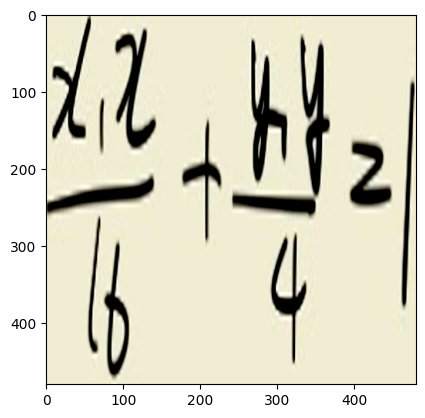

In [ ]:
plt.imshow(sample["pixel_values"][0].permute(1,2,0))

## Splits 만들기

In [ ]:
# # train_test_split 사용하는 방법
# from sklearn.model_selection import train_test_split

# traIn_ds, val_ds = train_test_split(ds, test_size=0.1, random_state=CFG.seed)

# train_ds = traIn_ds.cast_column("image_path", ds_img())
# train_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

# val_gt_ds = val_ds
# val_ds = val_ds.cast_column("image_path", ds_img())
# val_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

In [ ]:
skf = StratifiedKFold(n_splits=80)

fold_idxs = []

for _, val_idxs in skf.split(ds["material_type"], y=ds["material_type"]):
    fold_idxs.append(val_idxs)

In [ ]:
fold_idxs

[array([   0,    1,    2, ..., 1646, 1647, 1649]),
 array([1569, 1570, 1571, ..., 3257, 3264, 3272]),
 array([3147, 3149, 3150, ..., 4937, 4943, 4952]),
 array([4709, 4711, 4712, ..., 6553, 6555, 6560]),
 array([6290, 6292, 6293, ..., 8195, 8197, 8198]),
 array([7860, 7861, 7864, ..., 9717, 9723, 9729]),
 array([ 9468,  9469,  9470, ..., 11199, 11204, 11209]),
 array([11087, 11088, 11093, ..., 12733, 12734, 12735]),
 array([12666, 12669, 12671, ..., 14315, 14318, 14319]),
 array([14237, 14238, 14248, ..., 15890, 15896, 15898]),
 array([15886, 15887, 15888, ..., 17481, 17483, 17484]),
 array([17454, 17457, 17462, ..., 19118, 19123, 19125]),
 array([19050, 19051, 19052, ..., 20659, 20661, 20662]),
 array([20631, 20638, 20651, ..., 22243, 22244, 22253]),
 array([22245, 22246, 22247, ..., 23848, 23849, 23850]),
 array([23765, 23771, 23772, ..., 25422, 25423, 25424]),
 array([25421, 25425, 25426, ..., 27100, 27102, 27106]),
 array([26979, 26980, 26981, ..., 28642, 28643, 28644]),
 array([28

In [ ]:
fold = 0
train_extracted = ds.select(
    list(chain(*[x for i, x in enumerate(fold_idxs) if i != fold]))
)

train_ds = train_extracted.cast_column("image_path", ds_img())
train_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

val_gt_ds = ds.select(fold_idxs[fold])
val_ds = val_gt_ds.cast_column("image_path", ds_img())
val_ds.set_transform(partial(preprocess, processor=processor, CFG=CFG))

gt_material_type = val_gt_ds["material_type"]
gt_texts = val_gt_ds['ground_truth']
gt_ids = val_gt_ds["id"]

i = 0
print(gt_material_type[i])
print(gt_texts[i])
print(gt_ids[i])
print(Counter(gt_material_type))

손글씨
<TPT><hand><line><latex>\frac{x_{1} x}{16}+\frac{y_{1} y}{4}=1</latex></line>
ec0d2b7b-4393-424d-9438-90c20a10a4b0
Counter({'손글씨': 1217, '인쇄체': 372})


## `ids` 가 batch 마다 전부 같은 길이를 가지도록 하는 collate function

In [ ]:
pad_token_id = processor.tokenizer.pad_token_id


def collate_fn(samples: List[Dict[str, Union[torch.Tensor, List[int], str]]]) -> Dict[str, Union[torch.Tensor, List[str]]]:
    """
    Custom collate function for DataLoader.

    This function takes a list of samples and combines them into a batch with
    properly padded input_ids.

    Args:
        samples (List[Dict[str, Union[torch.Tensor, List[int], str]]]):
            A list of samples, where each sample is a dictionary containing
            "pixel_values" (torch.Tensor), "input_ids" (List[int]), and "id" (str).

    Returns:
        Dict[str, Union[torch.Tensor, List[str]]]:
            A dictionary containing the combined pixel values, padded input_ids, and ids.
    """

    batch = {}

    batch["pixel_values"] = torch.stack([x["pixel_values"] for x in samples])

    max_length = max([len(x["input_ids"]) for x in samples])

    # Make a multiple of 8 to efficiently use the tensor cores
    if max_length % 8 != 0:
        max_length = (max_length // 8 + 1) * 8

    input_ids = [
        x["input_ids"] + [pad_token_id] * (max_length - len(x["input_ids"]))
        for x in samples
    ]

    labels = torch.tensor(input_ids)
    labels[labels == pad_token_id] = -100 # ignore loss on padding tokens
    batch["labels"] = labels

    batch["id"] = [x["id"] for x in samples]

    return batch

## Dataloaders

- Validation은 generation을 사용하기 때문에 굉장히 느리다.
- 따라서 sample의 일부를 적게만 사용한다.

In [ ]:
if CFG.debug:
    train_ds = train_ds.select(range(100))
    val_ds = val_ds.select(range(100))

train_dataloader = DataLoader(
    train_ds,
    batch_size=CFG.batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=CFG.num_workers,
)
val_dataloader = DataLoader(
    val_ds,
    batch_size=CFG.batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=CFG.num_workers,
)

num_training_steps = len(train_dataloader) * CFG.epochs // CFG.gpus

batch = next(iter(train_dataloader))

batch.keys(), [(k, v.shape) for k, v in batch.items() if k != "id"]

(dict_keys(['pixel_values', 'labels', 'id']),
 [('pixel_values', torch.Size([8, 3, 480, 480])),
  ('labels', torch.Size([8, 48]))])

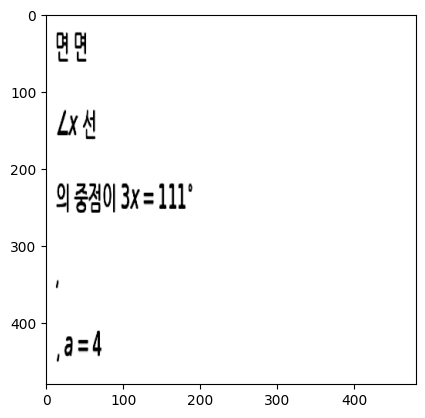

In [ ]:
plt.imshow(batch['pixel_values'][0].permute(1,2,0))

In [ ]:
batch['labels'][0]

tensor([57526, 57532, 57527, 42364, 42364, 57528, 57527, 57529, 58092, 42990,
        57790,   568, 57530,  1274, 57528, 57527, 27617, 44343,  1035, 42990,
        57529, 58092,  9066, 40392, 25544, 38354, 53163, 32650, 32650, 57956,
        42990, 42116, 57530, 57528, 57527, 42990, 35815, 57528, 57527, 42990,
        35815, 42990, 57529, 58092, 54915,  9026, 46702, 57530, 57528,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100])

## Metric을 계산하기 위한 function

In [ ]:
def rmse(y_true: List[float], y_pred: List[float]) -> float:
    """
    Calculate the Root Mean Square Error (RMSE) between the true and predicted values.

    Args:
        y_true (List[float]): The true values.
        y_pred (List[float]): The predicted values.

    Returns:
        float: The Root Mean Square Error.
    """
    return np.sqrt(np.mean(np.square(np.subtract(y_true, y_pred))))


def sigmoid(x: float) -> float:
    """
    Calculate the sigmoid function for the given value.

    Args:
        x (float): The input value.

    Returns:
        float: The result of the sigmoid function.
    """
    return 2 - 2 / (1 + np.exp(-x))


def normalized_rmse(y_true: List[float], y_pred: List[float]) -> float:
    """
    Calculate the normalized Root Mean Square Error (RMSE) between the true and predicted values.

    Args:
        y_true (List[float]): The true values.
        y_pred (List[float]): The predicted values.

    Returns:
        float: The normalized Root Mean Square Error.
    """
    numerator = rmse(y_true, y_pred)
    denominator = rmse(y_true, np.mean(y_true))

    if denominator == 0:
        if numerator == 0:
            return 1.0
        return 0.0

    return sigmoid(numerator / denominator)


def normalized_levenshtein_score(y_true: List[str], y_pred: List[str]) -> float:
    """
    Calculate the normalized Levenshtein distance between two lists of strings.

    Args:
        y_true (List[str]): The true values.
        y_pred (List[str]): The predicted values.

    Returns:
        float: The normalized Levenshtein distance.
    """
    total_distance = np.sum([levenshtein(yt, yp) for yt, yp in zip(y_true, y_pred)])
    length_sum = np.sum([len(yt) for yt in y_true])
    return sigmoid(total_distance / length_sum)

def score_series(
    y_true: List[Union[float, str]], y_pred: List[Union[float, str]]
) -> float:
    """
    Calculate the score for a series of true and predicted values.

    Args:
        y_true (List[Union[float, str]]): The true values.
        y_pred (List[Union[float, str]]): The predicted values.

    Returns:
        float: The score for the series.
    """
    if len(y_true) != len(y_pred):
        pass
        #return 0.0
    if isinstance(y_true[0], str):
        return f1_score(y_true, y_pred)
    else:
        # Since this is a generative model, there is a chance it doesn't produce a float.
        # In that case, we return 0.0.
        try:
            return mse(list(map(float, y_true)), list(map(float, y_pred)))
            # return normalized_rmse(y_true, list(map(float, y_pred)))
        except:
            return 0.0


def benetech_score(ground_truth: pd.DataFrame, predictions: pd.DataFrame) -> float:
    """Evaluate predictions using the metric from the Benetech - Making Graphs Accessible.

    Parameters
    ----------
    ground_truth: pd.DataFrame
        Has columns `[data_series, chart_type]` and an index `id`. Values in `data_series`
        should be either arrays of floats or arrays of strings.

    predictions: pd.DataFrame
    """
    if not ground_truth.index.equals(predictions.index):
        raise ValueError(
            "Must have exactly one prediction for each ground-truth instance."
        )
    if not ground_truth.columns.equals(predictions.columns):
        raise ValueError(f"Predictions must have columns: {ground_truth.columns}.")
    pairs = zip(
        ground_truth.itertuples(index=False), predictions.itertuples(index=False)
    )
    scores = []
    for (gt_series, gt_type), (pred_series, pred_type) in pairs:
        # if gt_type != pred_type:  # Check material_type condition
        #     scores.append(0.0)
        # else:  # Score with RMSE or Levenshtein as appropriate
        scores.append(score_series(gt_series, pred_series))

    ground_truth["score"] = scores

    grouped = ground_truth.groupby("material_type", as_index=False)["score"].mean()

    material_type2score = {
        material_type: score
        for material_type, score in zip(grouped["material_type"], grouped["score"])
    }

    return np.mean(scores), material_type2score

def f1_score(y_true: List[str], y_pred: List[str]) -> float:
    """
    Calculate the F1 score between the true and predicted values.

    Args:
        y_true (List[str]): The true values.
        y_pred (List[str]): The predicted values.

    Returns:
        float: The F1 score.
    """
    true_set = set(y_true)
    pred_set = set(y_pred)
    intersection = true_set.intersection(pred_set)
    precision = len(intersection) / len(pred_set) if len(pred_set) > 0 else 0.0
    recall = len(intersection) / len(true_set) if len(true_set) > 0 else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return f1

def mse(y_true: List[float], y_pred: List[float]) -> float:
    """
    Calculate the Mean Squared Error (MSE) between the true and predicted values.

    Args:
        y_true (List[float]): The true values.
        y_pred (List[float]): The predicted values.

    Returns:
        float: The Mean Squared Error.
    """
    return np.mean(np.square(np.subtract(y_true, y_pred)))

def string2doublet(pred_string: str) -> Tuple[str, List[str]]:
    """
    Convert a prediction string to a doublet of material type, and text.

    Args:
        pred_string (str): The prediction string.

    Returns:
        Tuple[str, List[str]]: A doublet of material type, and text.
    """

    material_type = "인쇄체"
    for tok in [HAND_TOKEN, PRINT_TOKEN]:
        if tok in pred_string:
            if tok == HAND_TOKEN:
                material_type = '손글씨'
            else:
                material_type = '인쇄체'

    pred_string = re.sub(r"<one>", "1", pred_string)

    text = pred_string

    if len(text) == 0:
        return material_type, []

    return material_type, text


def validation_metrics(val_outputs: List[str], val_ids: List[str], gt_df: pd.DataFrame) -> Dict[str, float]:
    """
    Calculate validation metrics for a set of outputs, ids, and ground truth dataframe.

    Args:
        val_outputs (List[str]): A list of validation outputs.
        val_ids (List[str]): A list of validation ids.
        gt_df (pd.DataFrame): The ground truth dataframe.

    Returns:
        Dict[str, float]: A dictionary containing the validation scores.
    """
    pred_doublets = []

    for example_output in val_outputs:
        pred_doublets.append(string2doublet(example_output))

    # Comment[전현욱] : 생각해보니 굳이 material type 별로 점수를 나눌 필요가 있을까 싶다
    pred_df = pd.DataFrame(
        index=val_ids,
        data={
            "text": [x[1] for x in pred_doublets],
            "material_type": [x[0] for x in pred_doublets],
        },
    )

    overall_score, material_type2score = benetech_score(
        gt_df.loc[pred_df.index.values], pred_df
    )

    return {
        "val_score": overall_score,
        **{f"{k}_score": v for k, v in material_type2score.items()},
    }

## Lightning Module

In [ ]:
import pytorch_lightning as pl
import gc
from transformers import PreTrainedTokenizerBase, PreTrainedModel

class DonutModelPLModule(pl.LightningModule):
    def __init__(self, processor: PreTrainedTokenizerBase, model: PreTrainedModel, gt_df: pd.DataFrame, num_training_steps: int):
        """
        A PyTorch Lightning module for the DonutModel.

        Args:
            processor (PreTrainedTokenizerBase): The tokenizer/processor for the model.
            model (PreTrainedModel): The pretrained model.
            gt_df (pd.DataFrame): The ground truth dataframe.
            num_training_steps (int): The number of training steps.
        """
        super().__init__()
        self.processor = processor
        self.model = model
        self.gt_df = gt_df
        self.num_training_steps = num_training_steps

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        gc.collect()
        torch.cuda.empty_cache()

        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int, dataset_idx: int = 0) -> None:
        pixel_values = batch["pixel_values"]
        batch_size = pixel_values.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full(
            (batch_size, 1),
            self.model.config.decoder_start_token_id,
            device=self.device,
        )

        outputs = self.model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=CFG.max_length,
            early_stopping=True,
            pad_token_id=self.processor.tokenizer.pad_token_id,
            eos_token_id=self.processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            top_k=1,
            bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

        self.val_outputs.extend(
            self.processor.tokenizer.batch_decode(outputs.sequences)
        )
        self.val_ids.extend(batch["id"])

    def on_validation_start(self) -> None:
        gc.collect()
        torch.cuda.empty_cache()

        self.val_outputs, self.val_ids = [], []

    def on_validation_epoch_end(self) -> None:

        metrics = validation_metrics(self.val_outputs, self.val_ids, self.gt_df)
        print("\n", metrics)

        self.log_dict(metrics)

        self.val_outputs, self.val_ids = [], []

    def configure_optimizers(self) -> torch.optim.Optimizer:

        optimizer = torch.optim.Adam(self.parameters(), lr=CFG.lr)

        return optimizer

### Model, Ground Truth DataFrame 생성

In [ ]:
gt_material_type = val_gt_ds["material_type"]
gt_texts = val_gt_ds["ground_truth"]
gt_ids = val_gt_ds["id"]

gt_df = pd.DataFrame(
    index=gt_ids,
    data={
        "text": gt_texts,
        "material_type": gt_material_type,
    },
)


model = VisionEncoderDecoderModel.from_pretrained(
    "naver-clova-ix/donut-base", config=config
)
model.decoder.resize_token_embeddings(len(processor.tokenizer))
model_module = DonutModelPLModule(processor, model, gt_df, num_training_steps)

In [ ]:
# Check if it works
outputs = model(batch["pixel_values"], labels=batch["labels"])

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

checkpoint_cb = ModelCheckpoint(CFG.output_path)

loggers = []

trainer = pl.Trainer(
        accelerator="gpu",
        devices=CFG.gpus,
        max_epochs=CFG.epochs,
        val_check_interval=CFG.val_check_interval,
        check_val_every_n_epoch=CFG.check_val_every_n_epoch,
        gradient_clip_val=CFG.gradient_clip_val,
        precision=16, # if you have tensor cores (t4, v100, a100, etc.) training will be 2x faster
        num_sanity_val_steps=5,
        callbacks=[checkpoint_cb],
        logger=loggers
)

# trainer.fit(model_module, train_dataloaders=train_dataloader)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [ ]:
# trainer.validate(model_module, dataloaders=val_dataloader)

In [ ]:
# check gt label
for i, batch in enumerate(val_dataloader):
  if i == 10:
    break
  for b in batch['labels']:
    tokens = []
    for token in b:
      if token != -100:
        tokens.append(token)
    print(processor.decode(tokens))

<TPT><hand><line><latex>\frac {x_{<one>} x}{16}+\frac {y_{<one>} y}{4}=1</latex></line>
<TPT><hand><line> 답 : 점ᄀ, 변ᄂᄀ, 각ᄂᄀ ᄆ</line>
<TPT><hand><line><latex> m \times n=-1</latex></line>
<TPT><print><line> 곡선 <latex>\displaystyle f'(x)=6{x}^{2}+6x+k</latex></line><line><latex>\displaystyle {x}^{2}=8</latex> <latex>\displaystyle y={x}^{2}</latex></line><line>또 는 <latex>\displaystyle \therefore {(a-b)}^{2}={(a+b)}^{2}-4ab={6}^{2}-4(-2)=44</latex></line><line> 위의 점이므로 <latex>\displaystyle x</latex></line><line><latex>\displaystyle (-2,6)</latex> 는</line>
<TPT><hand><line><latex>\overline {\text {AD}}=3 \sqrt {7}</latex></line>
<TPT><hand><line><latex> 2 a+b+c=-\frac {15}{2}+\frac {15}{2}+\frac {-53}{4}=-\frac {53}{4}</latex></line>
<TPT><hand><line><latex> p=\frac {4! / 3!}{16}=1 / 4 \quad x \sim B(n, 1 / 4)</latex></line>
<TPT><print><line><latex>\displaystyle {(x+\frac {<one>}{x})}^{3}=_{3}C_{0}{x}^{0}{(\frac {<one>}{x})}^{3}+_{3}C_{<one>}{x}^{}{(\frac {<one>}{x})}^{2}+_{3}C_{2}{x}^{2}{(

## Test

In [ ]:
test_img_paths = glob.glob('/content/kr-img2latex/data/test/images/*')
sample_test_img_path = np.random.choice(test_img_paths)
sample_test_json_file = sample_test_img_path.replace('images','annotations').replace('.png','.json')

In [ ]:
# for personal data
# sample_test_img_path = '/content/mypic.jpg'

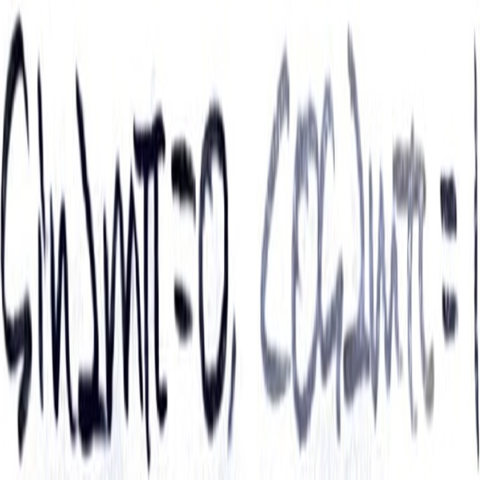

In [ ]:
sample_test_img = Image.open(sample_test_img_path).convert("RGB").resize((CFG.image_width, CFG.image_height))
sample_test_img

In [ ]:
pixel_values = processor(sample_test_img, random_padding=True).pixel_values
pixel_values = torch.FloatTensor(pixel_values).to('cuda')

decoder_input_ids = torch.full(
            (1, 1),
            model.config.decoder_start_token_id,
            device='cuda',
)

model.cuda()

outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=CFG.max_length,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            top_k=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
)

<ipython-input-52-54a5a1fc6274>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  pixel_values = torch.FloatTensor(pixel_values).to('cuda')


In [ ]:
processor.tokenizer.batch_decode(outputs.sequences)

['<TPT>。</s>']

In [ ]:
get_gt_string(sample_test_json_file)['ground_truth']

'<TPT><hand><line><latex>\\sin 2m \\pi=0, \\cos 2m \\pi=1</latex></line>'

In [ ]:
mse_score(processor.tokenizer.batch_decode(outputs.sequences),
                             [get_gt_string(sample_test_json_file)['ground_truth']])

3249.0

## Save Model

In [ ]:
model_module.model.save_pretrained('/content/drive/MyDrive/programmers/Team_caffeine_holic/05.Model/Main/epoch-2, batch-4, img_size-504, max_length-504/Donut-mathOCR-model')
model_module.processor.save_pretrained('/content/drive/MyDrive/programmers/Team_caffeine_holic/05.Model/Main/epoch-2, batch-4, img_size-504, max_length-504/Donut-mathOCR-processor')
config.save_pretrained('/content/drive/MyDrive/programmers/Team_caffeine_holic/05.Model/Main/epoch-2, batch-4, img_size-504, max_length-504/Donut-mathOCR-config')

## Load Model

In [ ]:
new_config = VisionEncoderDecoderConfig.from_pretrained("/content/drive/MyDrive/programmers/Team_caffeine_holic/05.Model/Main/epoch-2, batch-4, img_size-504, max_length-504/Donut-mathOCR-config")
new_processor = DonutProcessor.from_pretrained("/content/drive/MyDrive/programmers/Team_caffeine_holic/05.Model/Main/epoch-2, batch-4, img_size-504, max_length-504/Donut-mathOCR-processor")
new_model =  VisionEncoderDecoderModel.from_pretrained(
    "/content/drive/MyDrive/programmers/Team_caffeine_holic/05.Model/Main/epoch-2, batch-4, img_size-504, max_length-504/Donut-mathOCR-model", config=new_config
)

In [ ]:
new_model.cuda()

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [ ]:
new_model_module = DonutModelPLModule(new_processor, new_model, gt_df, num_training_steps)

In [ ]:
new_trainer = pl.Trainer(
        accelerator="gpu",
        devices=CFG.gpus,
        max_epochs=CFG.epochs,
        val_check_interval=CFG.val_check_interval,
        check_val_every_n_epoch=CFG.check_val_every_n_epoch,
        gradient_clip_val=CFG.gradient_clip_val,
        precision=16, # if you have tensor cores (t4, v100, a100, etc.) training will be 2x faster
        num_sanity_val_steps=5,
        callbacks=[checkpoint_cb],
        logger=loggers
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [ ]:
new_trainer.validate(new_model_module, dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]


 {'val_score': 0.9422324445910084, '손글씨_score': 0.9264909261226513, '인쇄체_score': 0.9894569999960804}


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_score         │    0.9422324445910084     │
│       손글씨_score        │    0.9264909029006958     │
│       인쇄체_score        │    0.9894570112228394     │
└───────────────────────────┴───────────────────────────┘

[{'val_score': 0.9422324445910084,
  '손글씨_score': 0.9264909029006958,
  '인쇄체_score': 0.9894570112228394}]

## For Debug